### To describe the laboratory characteristics of patients in relation to their coronary calcification with multiple category

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_excel(r"C:\Users\lavan\Downloads\RA_NUIG\Zero calcium score updated 9 Oct 2025.xlsx", na_values=["", " ", "NA", "N/A"])
#columns hidden on the excel sheet were said to be irrelvant so they were removed
dropcolumns = ["height","weight", "record","reason___3", "reason___4","reason___5","other_symptoms",
               "bp", "systolic_blood_pressure", "diastoic_blood_pressure","hr", "country","mother", 
               "father","language","glucose","random","lip_a_nmol_l", "lipoprotein_a_mg_dl", 
               "laboratory_data_complete","ct___1","ct___2", "contrast","contrast_amount", "radiation",
               "calcification_score","percentile_rank","plaque_burden","clinical_impression",
               "ct_coronary_angiography_complete", "Unnamed: 74", "Unnamed: 75", "Presence of any plaque (yes=1; no=0)",
                "CADrads_classification", "type", "ast" , "ethnicity", "calcium",
                 "type","potassium" ,   #removed since they have 15% missing values
                 "height", "weight", "total_daily_dose_10","units_10","frequency_fibra","route_fibra",
                 "total_daily_dose_11","units_11","frequency_nico","route_nico",
               "name_of_drug_12","total_daily_dose_12", "units_12","frequency_cholest","route_chlo",
                 "name_of_drug_13","total_daily_dose_13","units_13","frequency_pcsk9",
                 "route_pcsk9","name_of_drug_14","total_daily_dose_14","units_14",
                 "frequency_rensins","route_rensie","name_of_drug_10", "drug_11", "name_of_statin",
                 "total_daily_dose_9", "route_statin", "units_9", "frequency_statin", "pcsk9_inhibitors","resins"
                 ,"nicotinic_acid_group", "Patients with ZERO CALCIUM SCORE (yes=1; no=0)"
#  "coronary_calcification_score","fibrates","nicotinic_acid_group", "cholesterol_absorption", "pcsk9_inhibitors","resins", "statins"
       
              ]
data = data.drop(columns=dropcolumns)
print(data.shape)

(794, 42)


### Classification of coronary calcification score

In [5]:
def agatston_category(x):
    if pd.isna(x):
        return np.nan
    if x == 0:
        return "0 (Absent/No risk)"
    if 0 < x <= 10:
        return "1–10 (Minimal)"
    if 10 < x <= 100:
        return "11–100 (Mild)"
    if 100 < x <= 400:
        return "101–400 (Moderate)"
    return ">400 (High)"  # x > 400

data["CAC_category"] = data["coronary_calcification_score"].apply(agatston_category)
#print(data["CAC_category"].head(20))


CAC_category
                     Count  Percent
CAC_category                      
0 (Absent/No risk)    389    48.99
11–100 (Mild)         149    18.77
101–400 (Moderate)    100    12.59
1–10 (Minimal)         85    10.71
>400 (High)            71     8.94


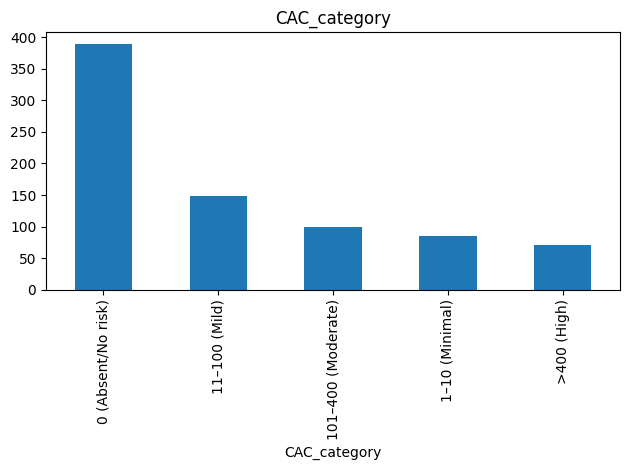

In [6]:
import matplotlib.pyplot as plt

def show_freqs(data, cols, plot=False):
    for c in cols:
        cnt = data[c].value_counts(dropna=False)
        pct = (cnt / cnt.sum() * 100).round(2)
        print(f"\n{c}\n", pd.DataFrame({"Count": cnt, "Percent": pct}))
        if plot:
            cnt.plot(kind="bar"); plt.title(c); plt.tight_layout(); plt.show()
show_freqs(data, ["CAC_category"], plot = True)

In [52]:
#show_freqs(data, ["hypertension", "hyperlipidemia", "diabetes", "family", "stroke"], plot=False)

In [ ]:
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

In [8]:
K = 5  
num_cols = ['bmi_cal', 'age', 'gender','alcohol', 'hypertension', 'hyperlipidemia',
            'diabetes', 'family', 'atherosclerosis', 'pad', 'cad', 'stroke', 'troponin', 'ck', 'hb', 
'wbc', 'plt', 'tc', 'tg', 'hdl', 'ldl', 'hba1c', 'crp', 'egfr', 'creatinine', 'bun', 'sodium', 
'lipoprotein_a', 'apoa', 'apob', 'ratio', 'bilirubin', 'alt', 'ggt', 'chloride', 'adjusted_calcium'] 
 # numeric 
cat_cols = [ 'smoking', 'statins', 'fibrates', 'cholesterol_absorption']  #cat


for c in cat_cols:
    data[c] = data[c].astype("category") 

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)



In [9]:
order = ["0 (Absent/No risk)", "11–100 (Mild)","101–400 (Moderate)","1–10 (Minimal)",">400 (High)" ]
mapper = {c:i for i,c in enumerate(order)} # since the variable is ordinal
 

target = "CAC_category"
X= data[num_cols + cat_cols].copy()
y = data[target].map(mapper).astype(int) 

In [10]:
 
model = XGBRegressor(
    tree_method="hist",
    enable_categorical=True,
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mae",
    random_state=42
)

In [11]:
# Train/valid split
from sklearn.model_selection import train_test_split
X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

model.fit(X_tr, y_tr)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric='mae', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, num_parallel_tree=None, ...)

In [12]:
# Predict 

K = y.nunique()
y_score = model.predict(X_va)
y_pred  = np.clip(np.rint(y_score), 0, K-1).astype(int)

In [13]:
# performace metrics
from sklearn.metrics import mean_absolute_error, cohen_kappa_score, accuracy_score, confusion_matrix, classification_report
mae = mean_absolute_error(y_va, y_pred)
qwk = cohen_kappa_score(y_va, y_pred, weights="quadratic")
acc = accuracy_score(y_va, y_pred)
cm  = confusion_matrix(y_va, y_pred)
print(f"MAE: {mae}\n\nQWK: {qwk}\n\nAccuracy: {acc}\n")

print(cm)
print(classification_report(y_va, y_pred, digits=3))


MAE: 1.0062893081761006

QWK: 0.24849535856370497

Accuracy: 0.3018867924528302

[[22 47  7  2  0]
 [ 2 16 11  1  0]
 [ 0 10 10  0  0]
 [ 4 12  1  0  0]
 [ 0  4  9  1  0]]
              precision    recall  f1-score   support

           0      0.786     0.282     0.415        78
           1      0.180     0.533     0.269        30
           2      0.263     0.500     0.345        20
           3      0.000     0.000     0.000        17
           4      0.000     0.000     0.000        14

    accuracy                          0.302       159
   macro avg      0.246     0.263     0.206       159
weighted avg      0.452     0.302     0.298       159



c:\Users\lavan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lavan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lavan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [14]:
import numpy as np
from sklearn.metrics import cohen_kappa_score

def best_thresholds(y_true, y_score, K, iters=300, noise=0.05):
    # init: equally spaced quantiles (exclude 0 and 1)
    q = np.linspace(0, 1, K+1)[1:-1]
    best = np.quantile(y_score, q)
    best_qwk = -1.0

    rng = np.random.default_rng(42)
    for _ in range(iters):
        trial = best + rng.normal(0, noise, size=K-1)
        trial = np.sort(trial)                        # enforce monotonicity
        # optional: ensure strict separation
        trial = np.clip(trial, trial.min()-1e-6, trial.max()+1e-6)
        y_pred = np.digitize(y_score, trial)
        qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
        if qwk > best_qwk:
            best_qwk, best = qwk, trial
    return best

cuts = best_thresholds(y_va, y_score, K)
y_pred = np.digitize(y_score, cuts)


In [15]:
import numpy as np
vals, cnts = np.unique(y_tr, return_counts=True)
w_map = {v: 1/c for v,c in zip(vals, cnts)}
w = np.array([w_map[v] for v in y_tr])
model.fit(X_tr, y_tr, sample_weight=w)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric='mae', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, num_parallel_tree=None, ...)

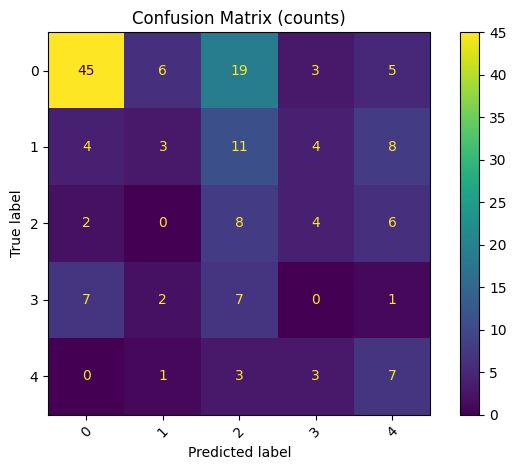

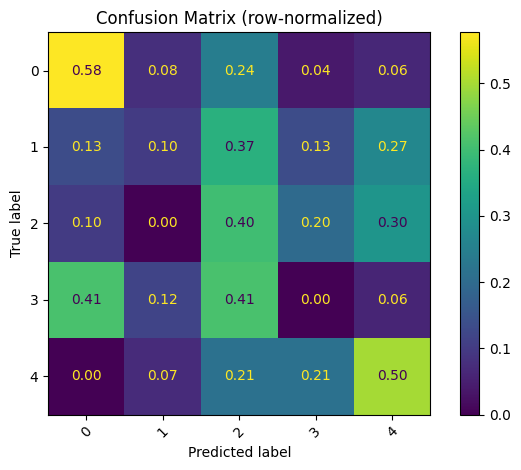

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

class_names = ["0","1","2","3","4"]  

# absolute counts
ConfusionMatrixDisplay.from_predictions(y_va, y_pred, display_labels=class_names)
plt.title("Confusion Matrix (counts)")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

# row-normalized (per-class recall)
ConfusionMatrixDisplay.from_predictions(y_va, y_pred, display_labels=class_names, normalize="true", values_format=".2f")
plt.title("Confusion Matrix (row-normalized)")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()
